In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [2]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [3]:
def read_imdb(data_dir, is_train):
    '''读取 IMDb 评论数据集文本序列和标签'''
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][: 3], train_data[1][: 3]):
    print('标签：', y, 'review：', x[0: 60])

训练集数目： 25000
标签： 1 review： Bromwell High is a cartoon comedy. It ran at the same time a
标签： 1 review： Homelessness (or Houselessness as George Carlin stated) has 
标签： 1 review： Brilliant over-acting by Lesley Ann Warren. Best dramatic ho


In [4]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

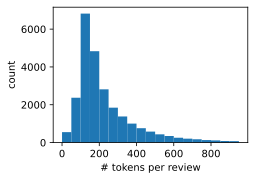

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

In [6]:
num_steps = 500 # 序列长度
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


In [7]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X: ', X.shape, ', y: ', y.shape)
    break
print('小批量数目：', len(train_iter))

X:  torch.Size([64, 500]) , y:  torch.Size([64])
小批量数目： 391


In [8]:
def load_data_imdb(batch_size, num_steps=500):
    '''返回数据迭代器和 IMDb 评论数据集的词表'''
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                               batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size)
    return train_iter, test_iter, vocab

In [9]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [10]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        # 双向 * 2，初始和最后时间步的隐状态连结 * 2
        self.decoder = nn.Linear(4 * num_hiddens, 2)
    
    def forward(self, inputs):
        # inputs: (batch_size, num_steps)
        # embedding = (num_steps, batch_size, embed_size)
        embeddings = self.embedding(inputs.T)
        # 为了提高内存的利用率和效率，调用 flatten_parameters 
        # 让 parameter 的数据存放成 contiguous chunk(连续的块)。
        # 多 GPU 必须加上这句
        self.encoder.flatten_parameters()
        # 返回上一个隐藏层在不同时间步的隐状态
        # outputs: (num_steps, batch_size, num_hiddens * 2)
        outputs, _ = self.encoder(embeddings)
        # 连结初始和最终时间步的隐状态
        # 形状为: (batch_size, num_hiddens * 4)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [11]:
embed_size, num_hiddens, num_layers = 100, 100, 2
devices = d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49347, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [12]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [13]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49347, 100])

In [14]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

loss 0.296, train acc 0.876, test acc 0.852
433.3 examples/sec on [device(type='cuda', index=0)]


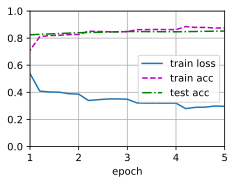

In [15]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices)

In [16]:
def predict_sentiment(net, vocab, sequence):
    '''预测文本序列的情感'''
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [17]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [18]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [19]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [20]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [21]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [22]:
def corr1d_multi_in(X, K):
    # 首先，遍历 X 和 K 的第 0 维，然后，把它们的结果相加
    return sum(corr1d(x, k) for x, k in zip(X, K))

In [23]:
X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
                 [1, 2, 3, 4, 5, 6, 7],
                 [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

In [24]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, 
                **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # 最大时间汇聚层没有参数，因此可以共享实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            # 输入通道在这里是词向量的维度（这里有两个嵌入层）
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))
        
    def forward(self, inputs):
        # 沿着词向量维度将两个嵌入层连结起来
        # 每个嵌入层的输出形状：(batch_size, num_steps, embed_size)
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # (batch_size, embed_size * 2, num_steps) 输入通道作为第二维
        embeddings = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的形状为：(batch_size, out_channels, 1)
        # 删除最后一个维度并沿通道维度连结
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs
        ], dim=1)
        # encoding: (batch_size, sum(num_channels))
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [25]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        
net.apply(init_weights)

TextCNN(
  (embedding): Embedding(49347, 100)
  (constant_embedding): Embedding(49347, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=2, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
)

In [26]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

loss 0.066, train acc 0.979, test acc 0.870
1025.3 examples/sec on [device(type='cuda', index=0)]


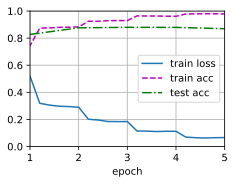

In [27]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [28]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [29]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [30]:
import re

#@save
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

# data_dir = d2l.download_extract('SNLI')
data_dir = '../data/snli_1.0/snli_1.0'

In [31]:
def read_snli(data_dir, is_train):
    '''将 SNLI 数据集解析为前提、假设和标签'''
    def extract_text(s):
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # 用一个空格替换两个或多个连续的空格
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

In [32]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][: 3], train_data[1][: 3], train_data[2][: 3]):
    print('前提：', x0)
    print('假设：', x1)
    print('标签：', y)

前提： A person on a horse jumps over a broken down airplane .
假设： A person is training his horse for a competition .
标签： 2
前提： A person on a horse jumps over a broken down airplane .
假设： A person is at a diner , ordering an omelette .
标签： 1
前提： A person on a horse jumps over a broken down airplane .
假设： A person is outdoors , on a horse .
标签： 0


In [33]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


In [34]:
class SNLIDataset(torch.utils.data.Dataset):
    '''用于加载 SNLI 数据集的自定义数据集'''
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + \
                all_hypothesis_tokens, min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')
        
    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                            for line in lines])
    
    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.premises)

In [35]:
def load_data_snli(batch_size, num_steps=50):
    '''下载 SNLI 数据集并返回数据迭代器和词表'''
    num_workers = d2l.get_dataloader_workers()
    # data_dir = d2l.download_extract('SNLI')
    data_dir = '../data/snli_1.0/snli_1.0'
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    # 必须使用从训练集构造的词表作为测试集的词表
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

In [36]:
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples


18678

In [37]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


In [38]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [39]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)
        
    def forward(self, A, B):
        # A / B: (batch_size, 序列 A/B 的词元数, embed_size)
        # f_A / f_B: (batch_size, 序列 A/B 的词元数, num_hiddens)
        f_A = self.f(A)
        f_B = self.f(B)
        # e: (batch_size, num_steps_A, num_steps_B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # 意味着序列 B 被软对齐到序列 A 的每个词元
        # F.softmax() => (batch_size, num_steps_A, num_steps_B)
        # B: (batch_size, num_steps_B, embed_size)
        # beta: (batch_size, num_steps_A, embed_size)
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # 同理，序列 A 被软对齐到序列 B 的每个词元
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

In [40]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)
        
    def forward(self, A, B, beta, alpha):
        # torch.cat() => (batch_size, num_steps_A/B, embed_size * 2)
        # 因此 num_inputs = embed_size * 2
        # V_A/B: (batch_size, num_steps_A/B, num_hiddens)
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [41]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        # 这里设置为 True 好像没用
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)
        
    def forward(self, V_A, V_B):
        # V_A/B: (batch_size, num_hiddens)
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # torch.cat() => (batch_size, num_hiddens * 2)
        # 因此 num_inputs = num_hiddens * 2
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [42]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        # num_inputs_attend = embed_size
        # num_inputs_compare = embed_size * 2
        # num_inputs_agg = num_hiddens * 2
        
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # => (batch_size, num_steps_A/B, embed_size)
        
        self.attend = Attend(num_inputs_attend, num_hiddens)
        # => (batch_size, num_steps_A/B, embed_size)
        
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # => (batch_size, num_steps_A/B, num_hiddens)
        
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)
        # => (batch_size, num_outputs)
        
    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

In [43]:
batch_size, num_steps = 256, 50
train_iter, test_iter, vocab = load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [44]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
        ...,
        [ 0.2871, -0.5999,  0.4688,  ...,  0.3639, -0.8138, -0.2211],
        [ 0.9682,  0.0718,  0.1710,  ...,  0.1024,  1.3345, -0.4854],
        [ 0.1964,  0.0332,  0.1263,  ...,  0.1077,  0.0260,  0.8928]])

loss 0.496, train acc 0.805, test acc 0.821
6520.4 examples/sec on [device(type='cuda', index=0)]


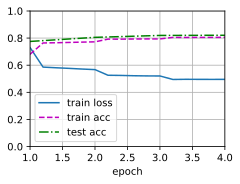

In [45]:
lr, num_epochs = 0.001, 4
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices)

In [46]:
def predict_snli(net, vocab, premise, hypothesis):
    '''预测前提和假设之间的逻辑关系'''
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                              hypothesis.reshape((1, -1))]), dim=1)
    return 'entailment' if label == 0 else 'contradiction' if label == 1 \
            else 'neutral'

In [47]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

In [48]:
import json
import multiprocessing

In [49]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [50]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以及加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
                                                    'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
                                                vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=num_heads, num_layers=num_layers, 
                         dropout=dropout, max_len=max_len, key_size=256, 
                         query_size=256, value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练 BERT 参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

In [51]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [52]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
             for sentences in dataset[: 2]])]
        # all_premise_hypothesis_tokens:
        # [[p_tokens1, h_tokens1], ..., [p_tokensN, h_tokensN]]
        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')
        
    def _preprocess(self, all_premise_hypothesis_tokens):
        # pool = multiprocessing.Pool(4)
        # pool.map() 的第二个参数是一个可迭代对象，它会一个一个传入函数
        # out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        # out: [[token_ids1, segments1, valid_len1], ..., 
        #      [tokens_idsN, segmentsN, valid_lenN]]
        out = []
        for premise_hypothesis_tokens in all_premise_hypothesis_tokens:
            out.append(self._mp_worker(premise_hypothesis_tokens))
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))
    
    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                                    * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len
    
    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为 BERT 输入中的 '<cls>', '<sep>' 和 '<sep>' 词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
    
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.all_token_ids)

In [59]:
batch_size, max_len, num_workers = 512, 64, d2l.get_dataloader_workers()
# data_dir = d2l.download_extract('SNLI')
data_dir = '../data/snli_1.0/snli_1.0'
train_set = SNLIBERTDataset(read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                         num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                        num_workers=num_workers)

read 549367 examples
read 9824 examples


In [54]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)
        
    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In [60]:
net = BERTClassifier(bert)

loss 0.479, train acc 0.809, test acc 0.788
1915.6 examples/sec on [device(type='cuda', index=0)]


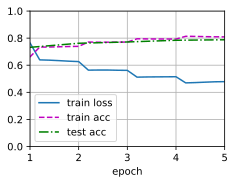

In [61]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices)